In [1]:
from keras.datasets import mnist
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
%matplotlib inline

/home/varshavskiisd/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
data = mnist.load_data()

In [3]:
num_input = data[0][0][0].shape[0] * data[0][0][0].shape[1] 
num_hidden = 144
epochs = 150
batch_size = 250

In [11]:
tf.reset_default_graph()

input_tensor = tf.placeholder(shape=[None, num_input], dtype=tf.float32)

weights_encoder = tf.Variable(tf.random_normal([num_input, num_hidden]))
bias_encoder = tf.Variable(tf.random_normal([num_hidden]))

weights_decoder = tf.Variable(tf.random_normal([num_hidden, num_input]))
bias_decoder = tf.Variable(tf.random_normal([num_input]))

def encoder(X_real):
    return tf.nn.sigmoid(tf.add(tf.matmul(X_real, weights_encoder), bias_encoder))

def decoder(X_zip):
    return tf.nn.sigmoid(tf.add(tf.matmul(X_zip, weights_decoder), bias_decoder))

hidden_tensor = encoder(input_tensor)

batch_mean, batch_var = tf.nn.moments(hidden_tensor,[0])

scale = tf.Variable(tf.ones([num_hidden]))
beta = tf.Variable(tf.zeros([num_hidden]))

hidden_tensor = tf.nn.batch_normalization(hidden_tensor, batch_mean, batch_var, beta, scale, 1e-3)

output_tensor = decoder(hidden_tensor)

loss = tf.reduce_mean(tf.pow(input_tensor - output_tensor, 2))
optimizer = tf.train.RMSPropOptimizer(learning_rate=1e-3, decay=3e-8)
gvs = optimizer.compute_gradients(loss)
optimizer_clipped = optimizer.apply_gradients([(tf.clip_by_value(grad, -1., 1.), var) for grad, var in gvs])

In [117]:
num_hidden = [392, 196, 98]
weights_hidden = [[num_hidden[i-1], num_hidden[i]] for i in range(1, len(num_hidden))]
weights_hidden += [[num_hidden[i], num_hidden[i-1]] for i in reversed(range(1, len(num_hidden)))]
weights_hidden = [[num_input, num_hidden[0]]] + weights_hidden
weights_hidden += [[num_hidden[0], num_input]]
weights_hidden

[[784, 392], [392, 196], [196, 98], [98, 196], [196, 392], [392, 784]]

In [118]:
bias_hidden = [num_hidden[i] for i in range(len(num_hidden))]
bias_hidden += [num_hidden[i] for i in reversed(range(len(num_hidden)-1))]
bias_hidden += [num_input]
bias_hidden

[392, 196, 98, 196, 392, 784]

In [135]:
num_hidden[1:] + list(reversed(num_hidden))[1:]

[196, 98, 196, 392]

In [136]:
class AutoEncoder:
    
    def __init__(self, params):
        num_input, num_hidden, b_norm = params['num_input'], params['num_hidden'], params['batch_normalisation']
        
        # Placeholders and variables used in graph
        self._input_tensor = tf.placeholder(shape=(None, 784), dtype=tf.float32)
        
        weights_hidden = [self.init_VarPair([num_hidden[i-1], num_hidden[i]]) for i in range(1, len(num_hidden))]
        weights_hidden += [self.init_VarPair([num_hidden[i], num_hidden[i-1]]) for i in reversed(range(1, len(num_hidden)))]
        weights_hidden = [self.init_VarPair([num_input, num_hidden[0]])] + weights_hidden
        weights_hidden += [self.init_VarPair([num_hidden[0], num_input])]
        
        bias_hidden = [self.init_VarSingle(num_hidden[i]) for i in range(len(num_hidden))]
        bias_hidden += [self.init_VarSingle(num_hidden[i]) for i in reversed(range(len(num_hidden)-1))]
        bias_hidden += [self.init_VarSingle(num_input)]

        
        # Graph structure
        hidden_tensor = self.coder(self._input_tensor, weights_hidden[0], bias_hidden[0])
        for i in zip(weights_hidden[1:-1], bias_hidden[1:-1], num_hidden[1:]+list(reversed(num_hidden))[1:]):
            if b_norm:
                hidden_tensor = self.normalisation(self.coder(hidden_tensor, i[0], i[1]), i[2])
            else:
                hidden_tensor = self.coder(hidden_tensor, i[0], i[1])
        self._output_tensor = self.coder(hidden_tensor, weights_hidden[-1:][0], bias_hidden[-1:][0])
        
        # Initialisation of loss funstion and optimisation method with constraits for weights changing
        self._loss = tf.reduce_mean(tf.pow(self._input_tensor - self._output_tensor, 2))
        self._optimizer = tf.train.RMSPropOptimizer(learning_rate=1e-3, decay=3e-8).minimize(self._loss)
        
    def coder(self, X, w, b):
        return tf.nn.sigmoid(tf.add(tf.matmul(X, w), b))
    
    def normalisation(self, tensor, count):
        batch_mean, batch_var = tf.nn.moments(tensor,[0])
        scale = tf.Variable(tf.ones([count]))
        beta = tf.Variable(tf.zeros([count]))
        return tf.nn.batch_normalization(tensor, batch_mean, batch_var, beta, scale, 1e-3)
    
    def init_VarPair(self, pair):
        return tf.Variable(tf.random_normal([pair[0], pair[1]]))

    def init_VarSingle(self, value):
        return tf.Variable(tf.random_normal([value]))
    
    @property
    def out(self):
        return self._output_tensor
    
    @property
    def loss(self):
        return self._loss
    
    @property
    def optimize(self):
        return self._optimizer
        
class Process:
    
    def __init__(self, data, params):
        self._epochs, self._batch_size = params['epochs'], params['batch_size']
        
        init = tf.global_variables_initializer()
        
        self._sess = tf.Session()
        self._sess.run(init)
        
        self._data, last, self._iterations = list(), 0, int(data.shape[0] / self._batch_size)
        for i in range(self._iterations):
            if i != 0:
                self._data.append(data[last:i*batch_size])
                last = i * batch_size
    
    def run(self, graph):
        for i in range(self._epochs):
            tmp = iter(self._data)
            for j in range(self._iterations-1):
                batch = next(tmp)
                _, l = self._sess.run([graph.optimize, graph.loss], feed_dict={graph._input_tensor : batch})
            if i % 5 == 0:
                print('Epoch:', i, 'Loss:', l)

In [ ]:
tf.reset_default_graph()
ae = AutoEncoder({
    'num_input' : 784,
    'num_hidden' : [392, 196, 98, 49],
    'batch_normalisation' : True
})
buff = MinMaxScaler().fit_transform(data[0][0].reshape(data[0][0].shape[0], num_input))
process = Process(buff, {'epochs' : 10, 'batch_size' : 250})
process.run(ae)

In [88]:
tf.reset_default_graph()
ae = AutoEncoder({
    'num_input' : 784,
    'num_hidden' : [392, 196],
    'input' : tf.placeholder(shape=(None, 784), dtype=tf.float32)
})

init = tf.global_variables_initializer()

sess = tf.Session()
sess.run(init)

# Small preprocess
buff = MinMaxScaler().fit_transform(data[0][0].reshape(data[0][0].shape[0], num_input))
X, last, iterations = list(), 0, int(data[0][0].shape[0] / batch_size)
for i in range(int(data[0][0].shape[0] / batch_size)):
    if i != 0:
        X.append(buff[last:i*batch_size])
        last = i * batch_size

# Training
for i in range(epochs):
    tmp = iter(X)
    for j in range(iterations-1):
        batch = next(tmp)
        _, l = sess.run([ae.optimize, ae.loss], feed_dict={ae._input_tensor : batch})
    print('Epoch:', i, 'Loss:', l)

/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype uint8 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


Epoch: 0 Loss: 0.244661
Epoch: 1 Loss: 0.0803636
Epoch: 2 Loss: 0.0643819
Epoch: 3 Loss: 0.0521874
Epoch: 4 Loss: 0.0492202
Epoch: 5 Loss: 0.04733
Epoch: 6 Loss: 0.045788
Epoch: 7 Loss: 0.0443011
Epoch: 8 Loss: 0.0429985
Epoch: 9 Loss: 0.041832
Epoch: 10 Loss: 0.040826
Epoch: 11 Loss: 0.0399039
Epoch: 12 Loss: 0.0389975
Epoch: 13 Loss: 0.0381926
Epoch: 14 Loss: 0.0374306
Epoch: 15 Loss: 0.0367219
Epoch: 16 Loss: 0.0360719
Epoch: 17 Loss: 0.0354679
Epoch: 18 Loss: 0.0349051
Epoch: 19 Loss: 0.0343681
Epoch: 20 Loss: 0.0338098
Epoch: 21 Loss: 0.0332831
Epoch: 22 Loss: 0.032812
Epoch: 23 Loss: 0.0323618
Epoch: 24 Loss: 0.0319133
Epoch: 25 Loss: 0.0315004
Epoch: 26 Loss: 0.0311068
Epoch: 27 Loss: 0.0307289
Epoch: 28 Loss: 0.0303667
Epoch: 29 Loss: 0.0300118
Epoch: 30 Loss: 0.0296649
Epoch: 31 Loss: 0.0293195
Epoch: 32 Loss: 0.0289936
Epoch: 33 Loss: 0.0286815
Epoch: 34 Loss: 0.0283851
Epoch: 35 Loss: 0.028104
Epoch: 36 Loss: 0.0278405
Epoch: 37 Loss: 0.0275873
Epoch: 38 Loss: 0.027334
Epoch

In [ ]:
init = tf.global_variables_initializer()

sess = tf.Session()
sess.run(init)

# Small preprocess
buff = MinMaxScaler().fit_transform(data[0][0].reshape(data[0][0].shape[0], num_input))
X, last, iterations = list(), 0, int(data[0][0].shape[0] / batch_size)
for i in range(int(data[0][0].shape[0] / batch_size)):
    if i != 0:
        X.append(buff[last:i*batch_size])
        last = i * batch_size
          
# Training            
for i in range(epochs):
    tmp = iter(X)
    for j in range(iterations-1):
        batch = next(tmp)
        _, l = sess.run([optimizer_clipped, loss], feed_dict={input_tensor : batch})
    print('Epoch:', i, 'Loss:', l)

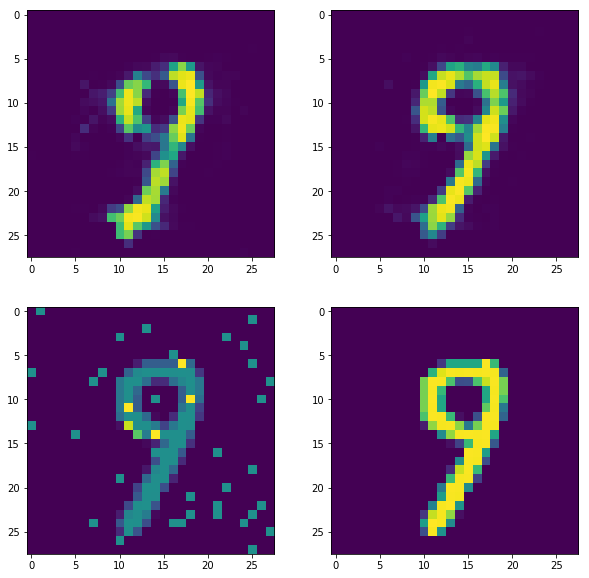

In [93]:
rand = np.random.choice(2, size=[batch_size, num_input], p=[0.95, 0.05])
plt.figure(figsize=(10, 10))
plt.subplot(2,2,1)
g = sess.run(ae._output_tensor, feed_dict={ ae._input_tensor : (X[5] + rand)})
plt.imshow(g[0].reshape([28, 28]))
plt.subplot(2,2,2)
g = sess.run(ae._output_tensor, feed_dict={ ae._input_tensor : X[5]})
plt.imshow(g[0].reshape([28, 28]))
plt.subplot(2,2,3)
plt.imshow((X[5][0] + rand[0]).reshape([28, 28]))
plt.subplot(2,2,4)
plt.imshow((X[5][0]).reshape([28, 28]))